# Import Package

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

sw_indo = stopwords.words('indonesian') + list(punctuation)

# Import Data

In [3]:
df = pd.read_csv('gojek_sentiment.csv')

df.head()

,review,rate
0,Apa aplikasi yang bagus untuk dengan mudah per...,positive
1,Aplikasi ini banyak membantu saya. Sekarang sa...,positive
2,Mengerikan. Antarmukanya sangat membingungkan....,negative
3,Aplikasi yang cukup mengesankan. Butuh waktu l...,positive
4,Aplikasi ini sebenarnya bagus dan sangat memba...,positive


In [4]:
df['rate'].value_counts(normalize=True)

negative    0.595398
positive    0.404602
Name: rate, dtype: float64

# Encoding

In [5]:
from gensim.models import FastText

In [7]:
ft = FastText.load('gojek_review.ft').wv

In [8]:
def sent_vector(sentence, w2v_model, stopwords):
    vecs = [w2v_model[i.lower()] for i in word_tokenize(sentence) if i not in stopwords]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec


def norm_sent_vector(sentence, w2v_model, stopwords):
    vecs = [w2v_model[i.lower()] for i in word_tokenize(sentence) if i not in stopwords]
    norm_vecs = [i/np.linalg.norm(i) for i in vecs if np.linalg.norm(i) > 0] 
    sent_vec = np.mean(norm_vecs, axis=0)
    return sent_vec


In [9]:
vecs = [norm_sent_vector(i, ft, sw_indo) for i in df.review]
vecs = np.array(vecs)
vecs

array([[ 0.00273822,  0.03709511, -0.01363738, ..., -0.00823015,
         0.00203149, -0.01493706],
       [ 0.0087053 ,  0.04502611,  0.01817481, ..., -0.00070511,
         0.01818974, -0.0024498 ],
       [-0.02843439,  0.01716434, -0.04212835, ...,  0.00434106,
         0.0696113 , -0.02012783],
       ...,
       [ 0.03076313,  0.02993486,  0.01262663, ...,  0.03607396,
         0.01402115, -0.04568438],
       [-0.00753346,  0.02596896, -0.04520364, ..., -0.00277178,
         0.05795477, -0.05117315],
       [ 0.00454746,  0.04478999, -0.02056354, ..., -0.01315011,
         0.02701264,  0.02685916]], dtype=float32)

In [10]:
vecs.shape

(1782, 128)

# Dataset Splitting

In [11]:
X = vecs
y = df.rate

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.25, random_state=42)

# Training Model

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp


In [13]:
pipeline = Pipeline([
    ('algo', SVC(max_iter=500))
])

In [14]:
model = RandomizedSearchCV(pipeline, rsp.svm_params, cv = 4, n_iter=50, n_jobs=-1, verbose=1)

model.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.3s finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('algo',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=500,
                                                  probability=False,
                                                  random_state=None,
                                                  shrinking=True, tol=0.001,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=50, n_jobs=-1,
  

In [15]:
print(model.score(X_train, y_train), model.score(X_test, y_test))

0.9258982035928144 0.8766816143497758


# Evaluation

In [16]:
from jcopml.plot import plot_confusion_matrix

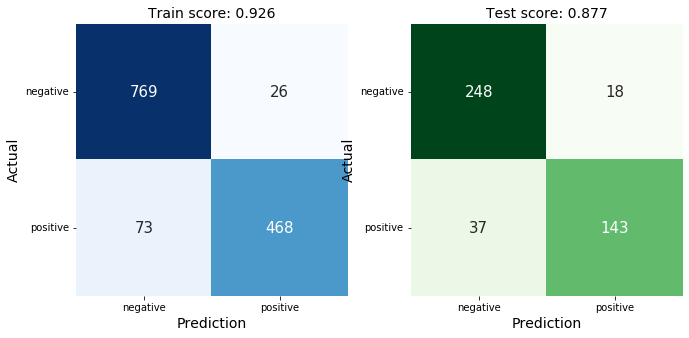

In [17]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)